# Load data

In [1]:
from pathlib import Path
from scipy import sparse
import pandas as pd
import numpy as np

DATA_DIR = Path("/home/ubuntu/ml4fg-final-project/COVID_single_cell_datasets")

# pull genes X cells counts matrix
X = sparse.load_npz(DATA_DIR /"counts.npz")
X = X.T.tocsr()

# pull names of which genes are in the counts matrix
var = pd.read_csv(DATA_DIR /"GSE158055_covid19_features.tsv.gz", sep="\t", header=None)
var.columns = ["gene"]
var.index = var["gene"]

# metadata for each of the ~1.5M cells, including which individual each cell is from
cell_meta = pd.read_csv(DATA_DIR / "GSE158055_cell_annotation.csv.gz")
cell_meta.index = cell_meta["cellName"]
cell_meta["sampleID"] = cell_meta["sampleID"].str.strip()
cell_meta["cellName"] = cell_meta["cellName"].str.strip()

# metadata for the samples (individuals), including their covid status
sample_metadata = pd.read_csv(DATA_DIR / "GSE158055_sample_metadata.tsv", sep="\t")
sample_metadata["Sample name"] = sample_metadata["Sample name"].str.strip()
sample_metadata = sample_metadata.rename(
    columns={"characteristics: SARS-CoV-2": "covid_status",
             "Sample name" : "sampleID", 
             "characteristics: CoVID-19 severity": "covid_severity"}
)
sample_metadata = sample_metadata[["sampleID", "covid_status", "covid_severity"]]

# merge cell metadata with individual metadata
n_cells_meta = len(cell_meta)
cell_meta = cell_meta.copy()
cell_meta["row_index"] = np.arange(n_cells_meta, dtype=np.int64)
obs = cell_meta.merge(
    sample_metadata,
    left_on="sampleID", right_on="sampleID", how="left"
)
obs.index = obs["cellName"]

# Preprocessing

In [2]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(X=X, obs=obs, var=var)
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

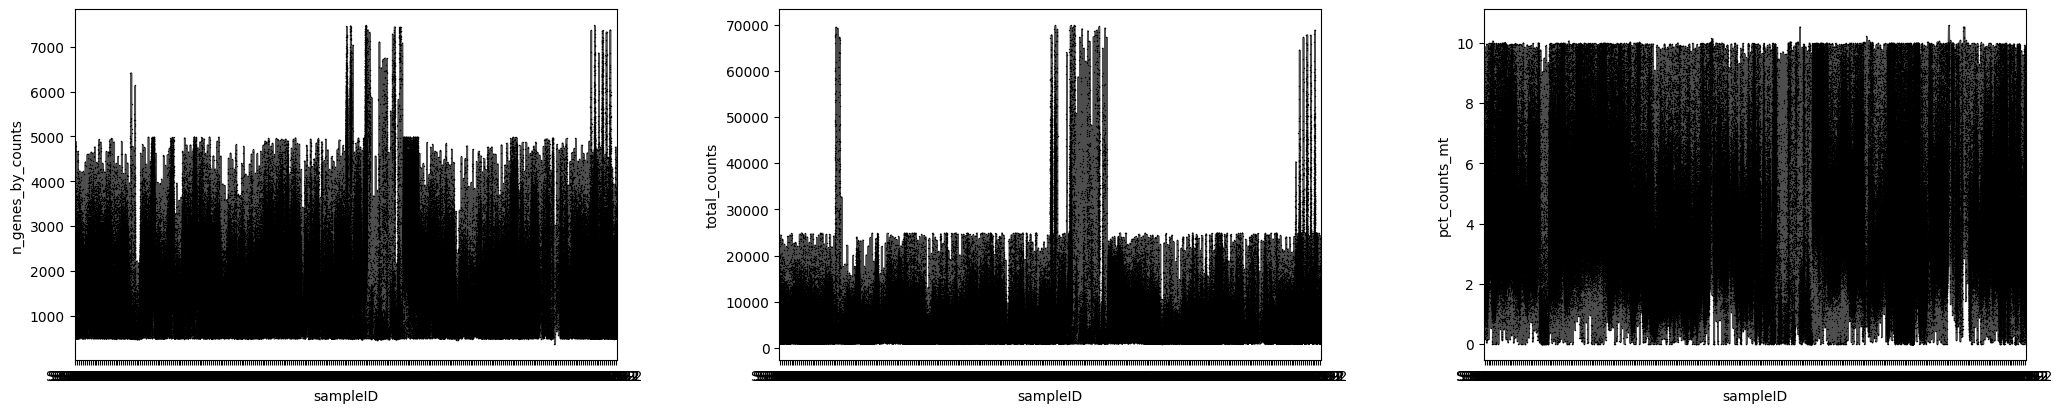

In [22]:
# full dataset visualization
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby="sampleID"
)

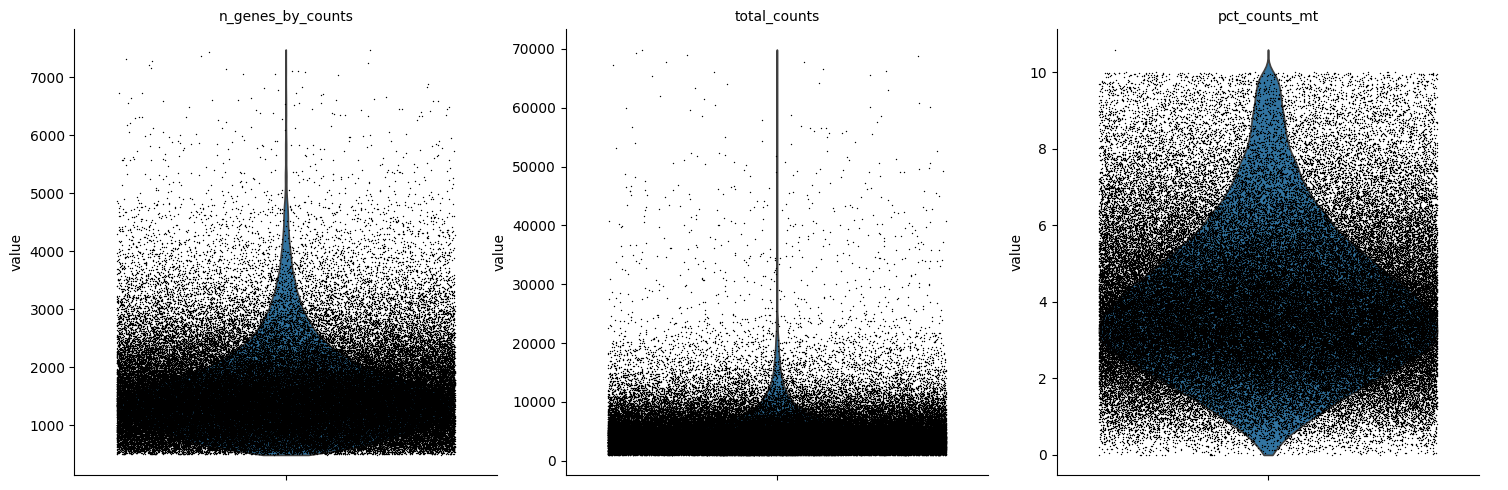

In [ ]:
# violin plots for random selection of cells
idx = np.random.choice(adata.n_obs, size=100000, replace=False)
sc.pl.violin(
    adata[idx],
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True,
    jitter=0.4,
)

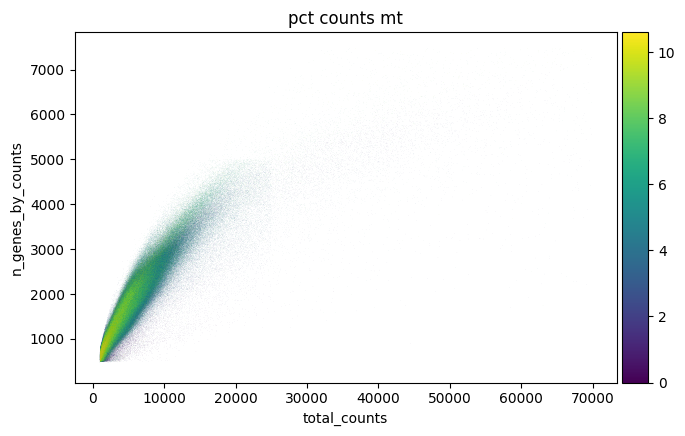

In [24]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [3]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

### Feature Selection: Highly Variable Genes

In [26]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sampleID")

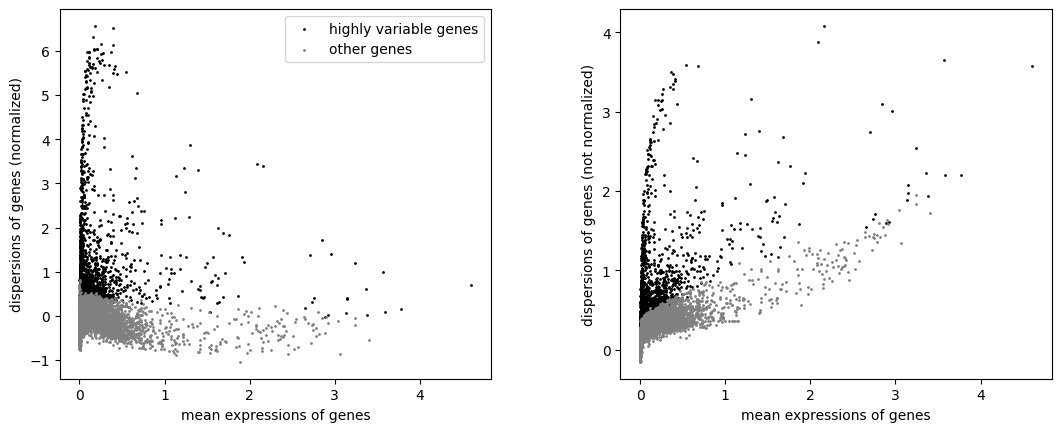

In [27]:
sc.pl.highly_variable_genes(adata)

### Dimensionality Reduction: PCA

#### Run PCA on ALL genes

In [4]:
pca_dim = 50

In [5]:
sc.tl.pca(adata, n_comps=pca_dim)

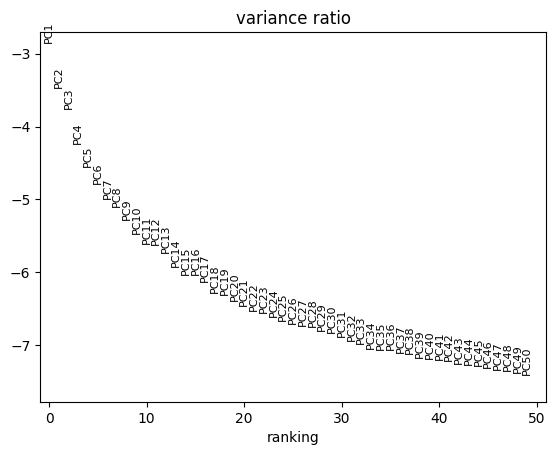

In [6]:
sc.pl.pca_variance_ratio(adata, n_pcs=pca_dim, log=True)

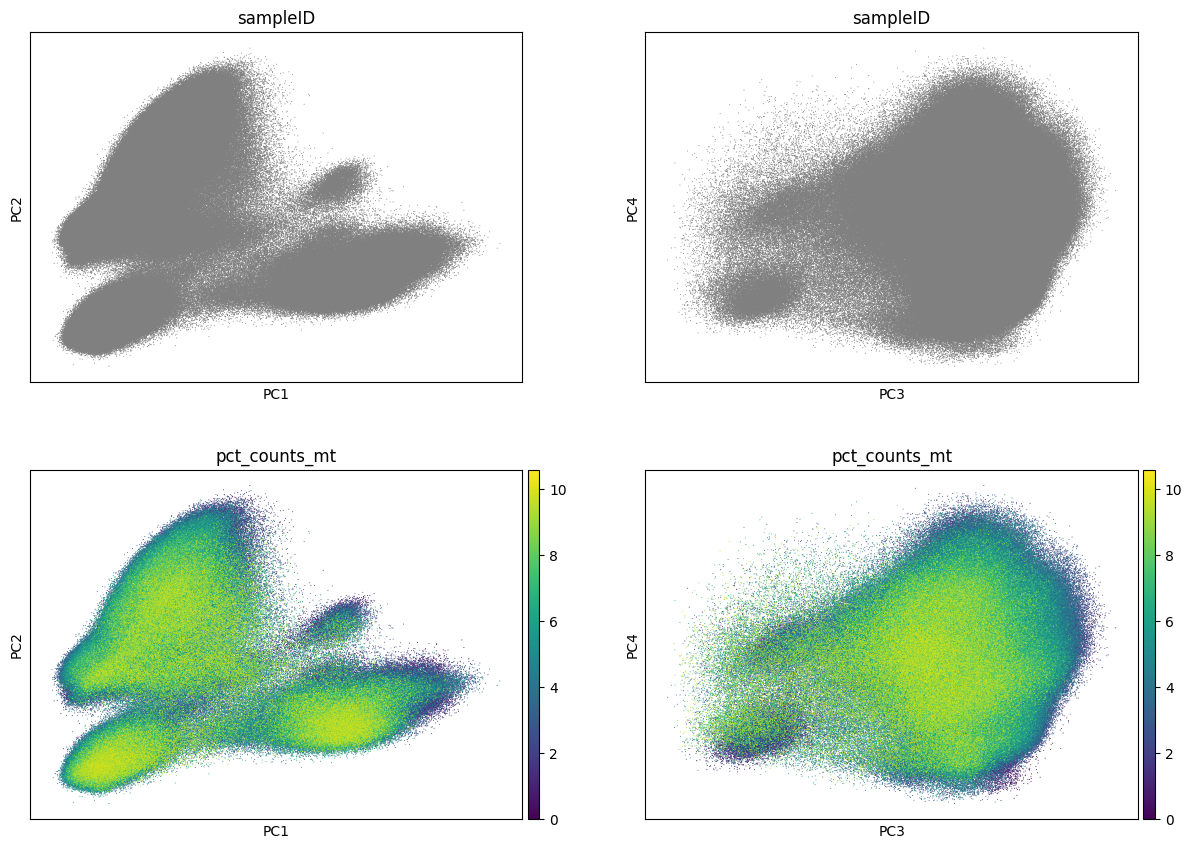

In [9]:
sc.pl.pca(
    adata,
    color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    legend_loc=None
)

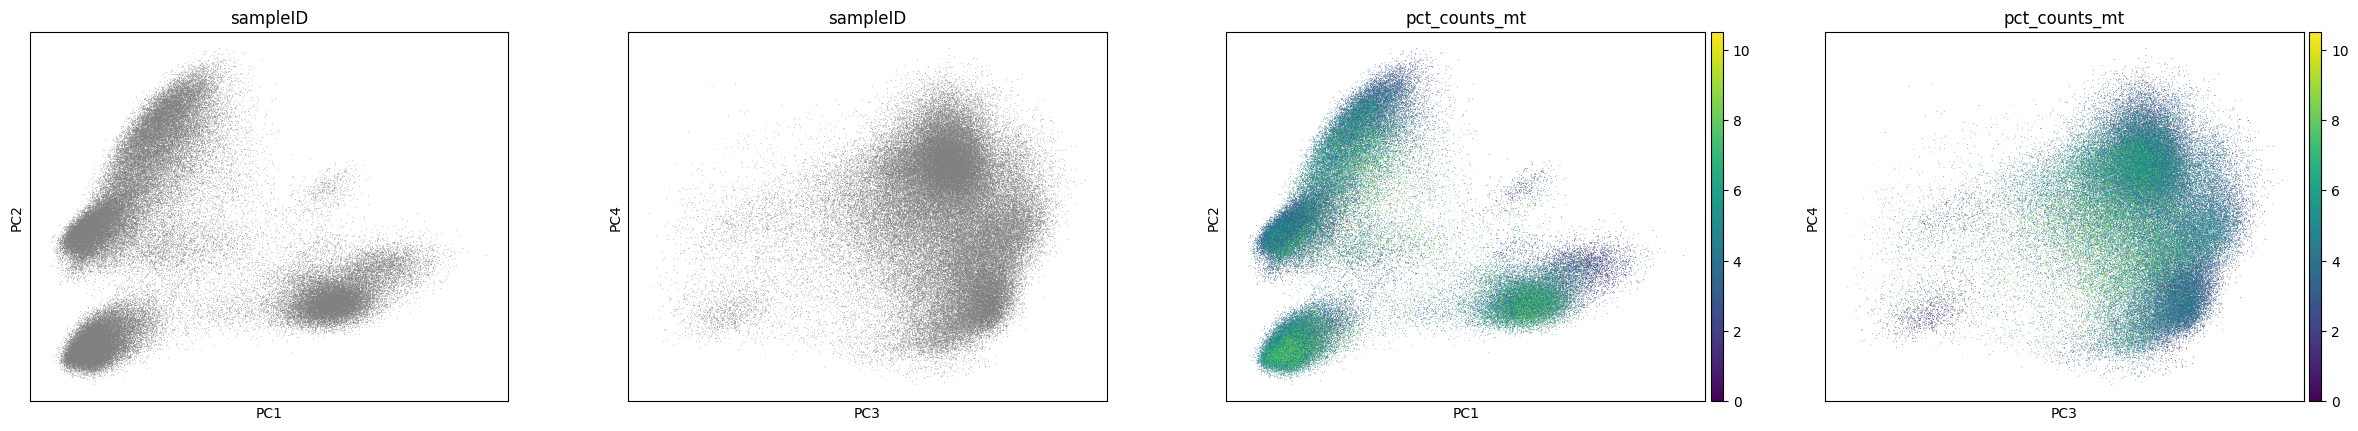

In [10]:
sc.pl.pca(adata[adata.obs.sample(100000).index], color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)], legend_loc=None)


#### Run PCA on Highly Variable Genes

In [37]:
adata_hvg = adata[:, adata.var['highly_variable']].copy()

In [ ]:
sc.tl.pca(adata_hvg, n_comps=pca_dim)

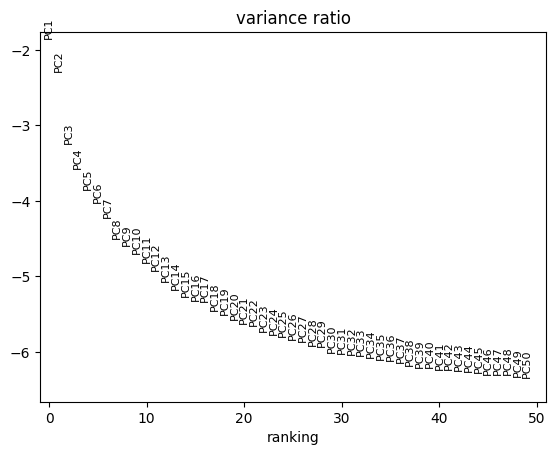

In [ ]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=pca_dim, log=True)

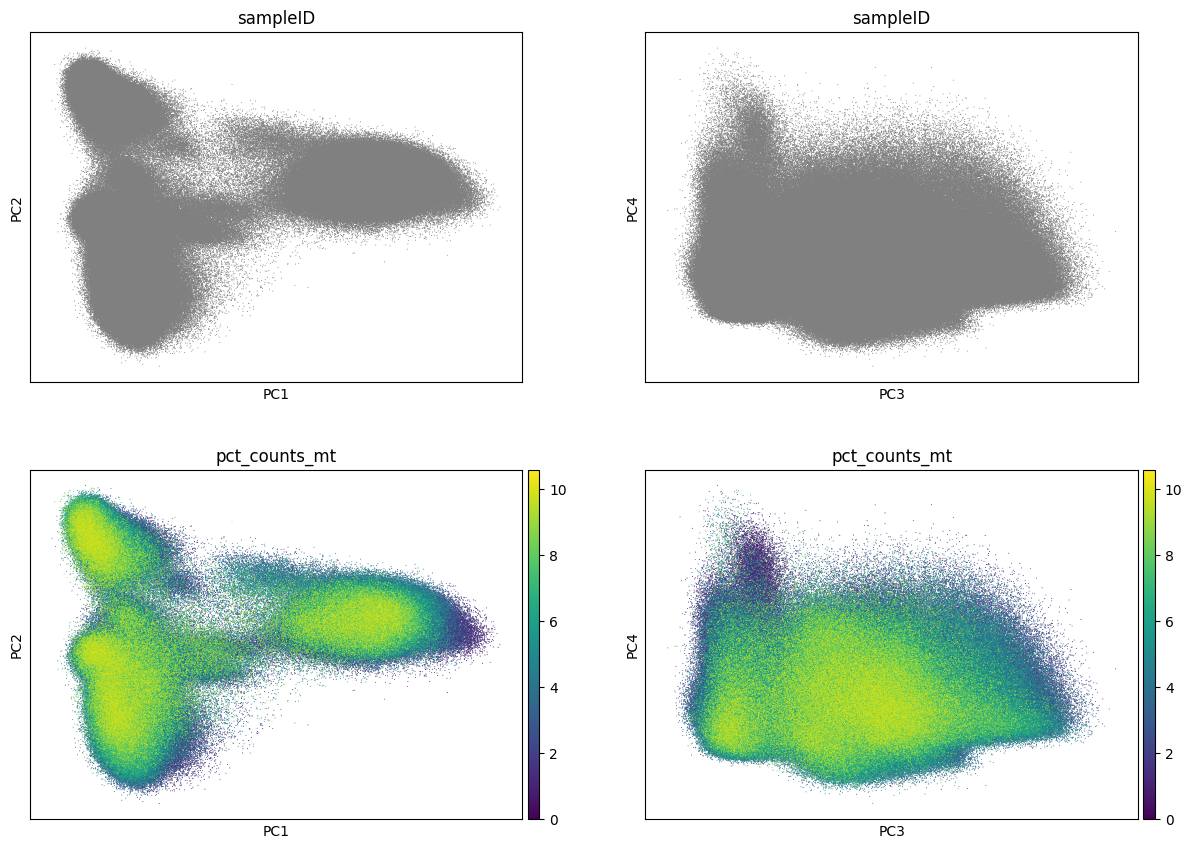

In [40]:
sc.pl.pca(
    adata_hvg,
    color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    legend_loc=None
)

Conclusion: looks really similar, use pca on full set of genes as the model input

# Prepare Model Input

In [7]:
obs = adata.obs.copy()
assert "sampleID" in obs.columns
assert "covid_status" in obs.columns

In [8]:
obs.columns

Index(['cellName', 'sampleID', 'celltype', 'majorType', 'row_index',
       'covid_status', 'covid_severity', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'],
      dtype='object')

In [9]:
import data_sampler

indiv_df = (
    obs.groupby("sampleID")["covid_status"]
       .apply(data_sampler.get_unique_label)
       .reset_index()
       )

# Keep only individuals with known (positive/negative) status
indiv_df = indiv_df.dropna(subset=["covid_status"])
indiv_df["covid_status"] = indiv_df["covid_status"].str.lower()
print(indiv_df["covid_status"].value_counts())

covid_status
positive    256
negative     28
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

# split individuals into train/val + test setse
train_ids, temp_ids = train_test_split(
    indiv_df["sampleID"].values,
    test_size=0.2,  # 80% train, 20% (val+test)
    stratify=indiv_df["covid_status"].values,
    random_state=42,
)

temp_df = indiv_df[indiv_df["sampleID"].isin(temp_ids)]

# split individuals into val and test sets
val_ids, test_ids = train_test_split(
    temp_df["sampleID"].values,
    test_size=0.5,  # 10% val, 10% test overall
    stratify=temp_df["covid_status"].values,
    random_state=42,
)

In [11]:
train_ids = set(train_ids)
val_ids = set(val_ids)
test_ids = set(test_ids)

print(f"Train individuals: {len(train_ids)}")
print(f"Val individuals:   {len(val_ids)}")
print(f"Test individuals:  {len(test_ids)}")

Train individuals: 227
Val individuals:   28
Test individuals:  29


In [12]:
train_mask = adata.obs["sampleID"].isin(train_ids)
val_mask   = adata.obs["sampleID"].isin(val_ids)
test_mask  = adata.obs["sampleID"].isin(test_ids)

adata_train = adata[train_mask].copy()
adata_val   = adata[val_mask].copy()
adata_test  = adata[test_mask].copy()

print(adata_train.shape, adata_val.shape, adata_test.shape)

(1163659, 27894) (155093, 27894) (143950, 27894)


In [13]:
seq_len = 64

train_dataset = data_sampler.CellSequenceDataset(
    adata_train,
    pca_key="X_pca",
    sample_key="sampleID",
    seq_len=seq_len,
    samples_per_epoch=100_000,  
)

val_dataset = data_sampler.CellSequenceDataset(
    adata_val,
    pca_key="X_pca",
    sample_key="sampleID",
    seq_len=seq_len,
    samples_per_epoch=10_000,
)

test_dataset = data_sampler.CellSequenceDataset(
    adata_test,
    pca_key="X_pca",
    sample_key="sampleID",
    seq_len=seq_len,
    samples_per_epoch=10_000,
)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,    # randomness is inside CellSequenceDataset
    num_workers=4,
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

# Initialize Model

In [15]:
import torch
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
assert device.type == "cuda" # ensure we are using GPU

Using device: cuda


# Training Loop

In [45]:
epochs = 50
lr = 1e-4
d_model = 256
n_layers = 6
n_heads = 4
d_hid = 512
dropout = 0.1
n_components = 8
max_seq_len = 256
batch_size = 32

In [46]:
from autoregressive_model import AutoregressiveCellModel

model = AutoregressiveCellModel(
    pca_dim = pca_dim,
    d_model=d_model,
    n_layers = n_layers,
    n_heads = n_heads,
    d_hid = d_hid,
    dropout = dropout,
    n_components = n_components,
    max_seq_len = max_seq_len,
)

model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

number of params: 3448872


In [47]:
OUTPUT_DIR = Path("/home/ubuntu/ml4fg-final-project/output_models")

optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [48]:
wandb.init(
    project="covid-cell-transformer-gmm",
    config={
        "pca_dim": pca_dim,
        "d_model": d_model,
        "n_layers": n_layers,
        "n_heads": n_heads,
        "dim_feedforward": d_hid,
        "n_components": n_components,
        "lr": lr,
        "batch_size": batch_size,
        "max_seq_len": max_seq_len,
        "epochs": epochs,
    }
)

wandb.define_metric("train/epoch_loss", summary="min", step_metric="epoch")
wandb.define_metric("val/epoch_loss", summary="min", step_metric="epoch")
wandb.define_metric("test/loss", summary="min")
wandb.watch(model, log = "gradients", log_freq=200)


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [49]:
import time
import copy
from train import train_one_epoch, evaluate

best_val_loss = float("inf")
best_model = None
best_epoch = -1

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    # 1) Train
    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch, scheduler)

    # 2) Validate
    val_loss = evaluate(model, val_loader, device)

    scheduler.step()

    elapsed = time.time() - epoch_start_time
    print(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"train loss {train_loss:5.4f} | val loss {val_loss:5.4f}"
    )

    # 3) Track best model by val loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        print(f"New best model at epoch {best_epoch} with val loss={best_val_loss:5.4f}")

    
    wandb.log(
        {
            "epoch": epoch,
            "train/epoch_loss": train_loss,
            "val/epoch_loss": val_loss,
            "lr": scheduler.get_last_lr()[0],
        },
    )


| end of epoch   1 | time: 57.62s | train loss 63.9133 | val loss 64.5154
New best model at epoch 1 with val loss=64.5154
| end of epoch   2 | time: 57.94s | train loss 59.7281 | val loss 64.5296
| end of epoch   3 | time: 58.04s | train loss 58.9764 | val loss 64.5721
| end of epoch   4 | time: 57.26s | train loss 58.3453 | val loss 64.2315
New best model at epoch 4 with val loss=64.2315
| end of epoch   5 | time: 57.52s | train loss 58.0339 | val loss 64.6174
| end of epoch   6 | time: 57.34s | train loss 57.9024 | val loss 64.7400
| end of epoch   7 | time: 57.68s | train loss 57.7850 | val loss 65.0187
| end of epoch   8 | time: 58.28s | train loss 57.6572 | val loss 65.2753
| end of epoch   9 | time: 57.68s | train loss 57.5852 | val loss 65.2990
| end of epoch  10 | time: 58.11s | train loss 57.5302 | val loss 65.6154
| end of epoch  11 | time: 57.72s | train loss 57.4731 | val loss 65.3672
| end of epoch  12 | time: 57.74s | train loss 57.4528 | val loss 65.6091
| end of epoch  

In [51]:
# save the best model
torch.save(best_model_state, OUTPUT_DIR / "best_model.pt")

Cell-Level Embeddings

In [52]:
from train import compute_model_embeddings

compute_model_embeddings(model, adata_test, pca_key="X_pca")

array([[ 0.13879815, -0.15625744,  0.0811462 , ..., -0.07644743,
         0.18242061,  0.10487006],
       [ 0.10100085, -0.1460114 ,  0.11581775, ..., -0.06552934,
         0.16451223,  0.11643846],
       [ 0.03893334, -0.2038703 ,  0.10326976, ..., -0.07038395,
         0.11650199,  0.13046086],
       ...,
       [ 0.02016377, -0.01959621, -0.06240408, ...,  0.10840971,
        -0.03892427,  0.02469462],
       [ 0.11240733,  0.02424311, -0.04397407, ...,  0.05878492,
        -0.06153414,  0.04648758],
       [ 0.0411666 , -0.02732902, -0.02394811, ...,  0.11483207,
        -0.03343681,  0.06653327]], shape=(143950, 256), dtype=float32)

In [53]:
adata_test_copy1 = adata_test.copy()
sc.pp.neighbors(adata_test_copy1, use_rep="X_pca")
sc.tl.umap(adata_test_copy1, min_dist=0.3)

In [54]:
adata_test_copy2 = adata_test.copy()
sc.pp.neighbors(adata_test_copy2, use_rep="X_model")
sc.tl.umap(adata_test_copy2, min_dist=0.3)

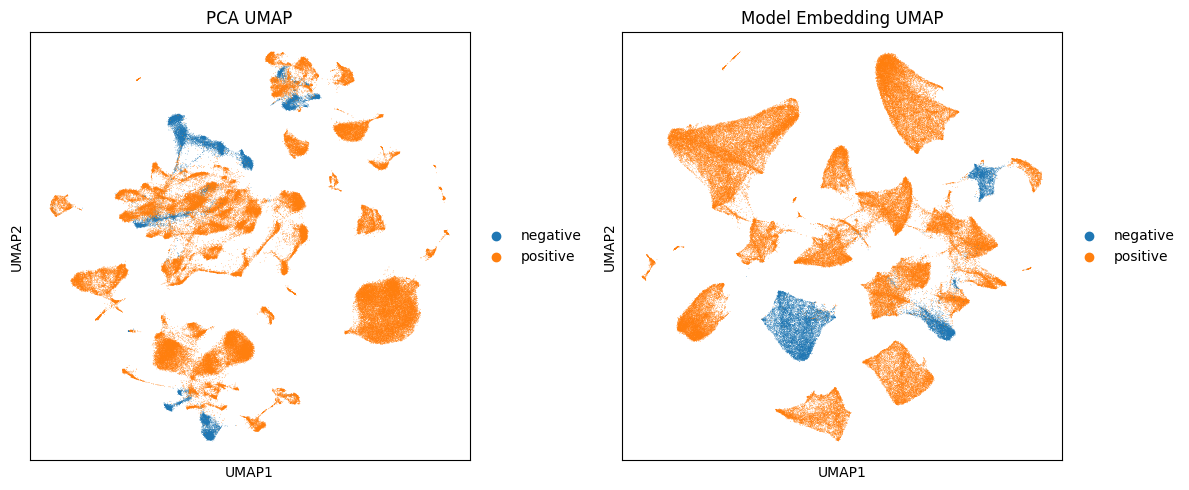

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata_test_copy1, color="covid_status", ax=axes[0], title="PCA UMAP", show=False)
sc.pl.umap(adata_test_copy2, color="covid_status", ax=axes[1], title="Model Embedding UMAP", show=False)
plt.tight_layout()
plt.show()    


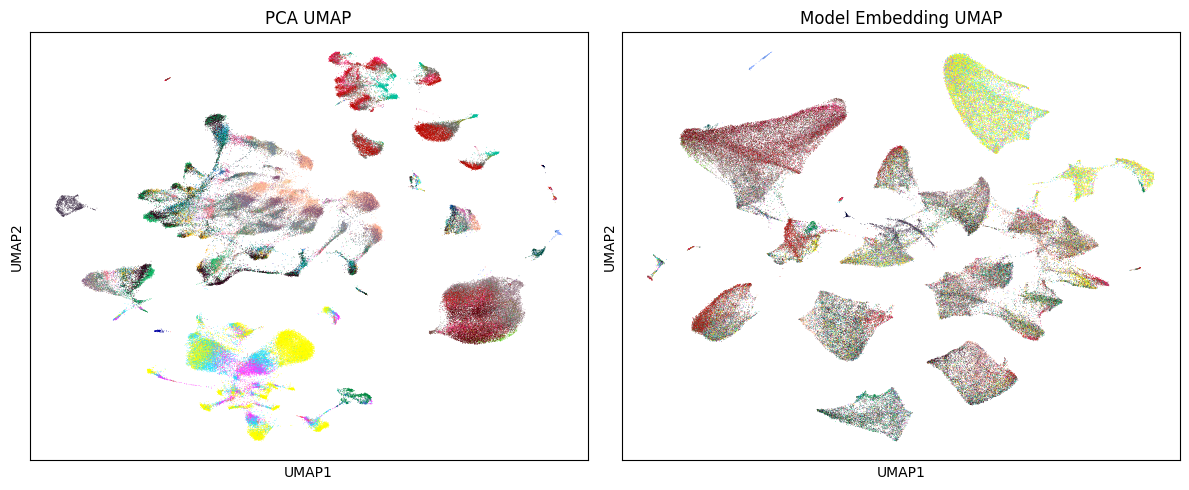

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata_test_copy1, color="celltype", ax=axes[0], title="PCA UMAP", show=False, legend_loc=None)
sc.pl.umap(adata_test_copy2, color="celltype", ax=axes[1], title="Model Embedding UMAP", show=False, legend_loc=None)
plt.tight_layout()
plt.show()   

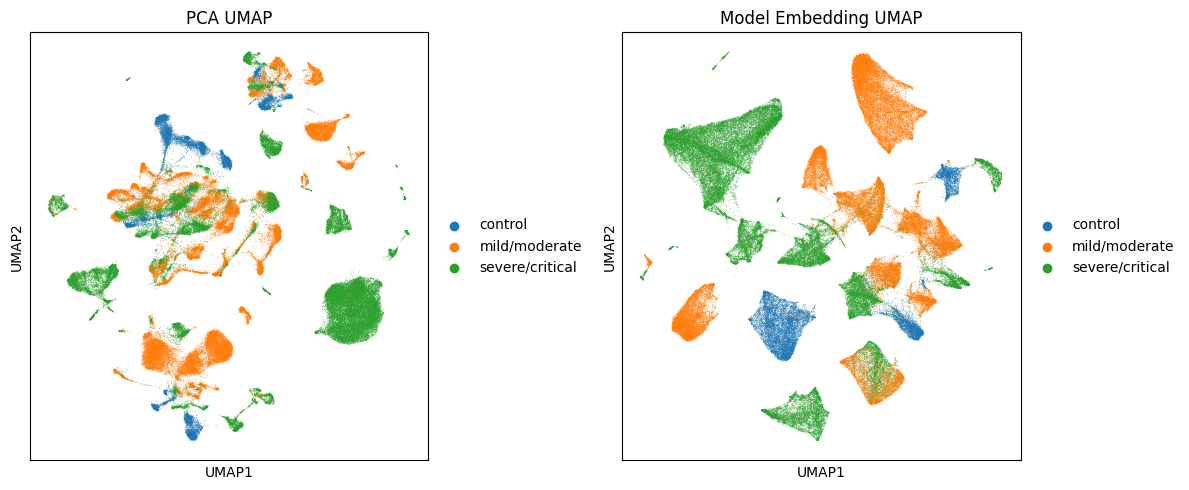

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata_test_copy1, color="covid_severity", ax=axes[0], title="PCA UMAP", show=False)
sc.pl.umap(adata_test_copy2, color="covid_severity", ax=axes[1], title="Model Embedding UMAP", show=False)
plt.tight_layout()
plt.show()   

Individual-level Embeddings

In [58]:
from train import compute_sequence_embeddings
import umap

embs, emb_labels = compute_sequence_embeddings(model, adata_test)

reducer = umap.UMAP(random_state=42)
umap_coords = reducer.fit_transform(embs)

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


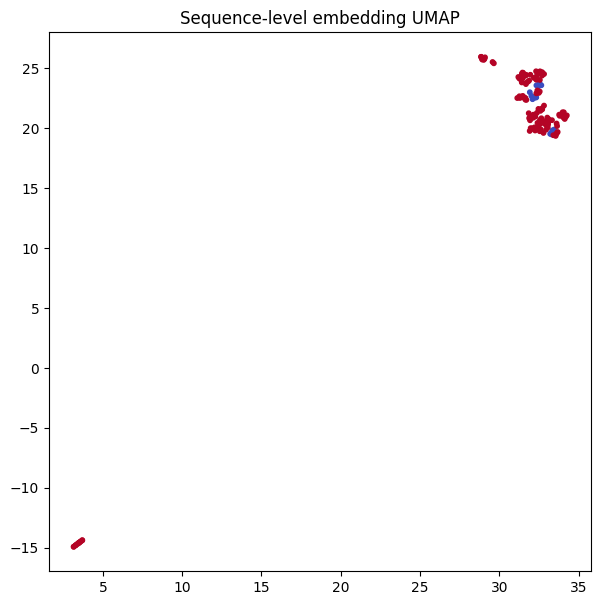

In [59]:
covid_labels = adata_test.obs.set_index("sampleID")["covid_status"].to_dict()
covid_colors = np.array([covid_labels[l] for l in emb_labels])

plt.figure(figsize=(7,7))
plt.scatter(umap_coords[:,0], umap_coords[:,1], c=(covid_colors=="positive"), cmap="coolwarm", s=10)
plt.title("Sequence-level embedding UMAP")
plt.show()

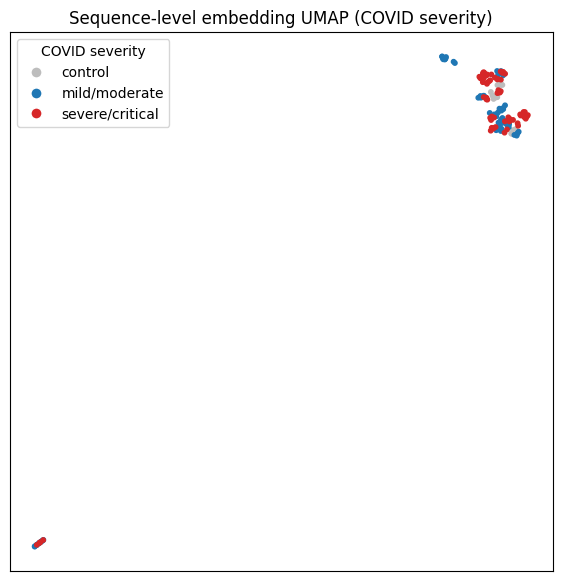

In [60]:
from matplotlib.colors import ListedColormap

covid_labels = adata_test.obs.set_index("sampleID")["covid_severity"].to_dict()
severity = np.array([covid_labels[l] for l in emb_labels])

categories = ["control", "mild/moderate", "severe/critical"]
cat_to_int = {cat: i for i, cat in enumerate(categories)}
severity_int = np.array([cat_to_int[c] for c in severity])
colors = ["#bdbdbd", "#1f77b4", "#d62728"]    # gray, blue, red
cmap = ListedColormap(colors)

plt.figure(figsize=(7, 7))
scatter = plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    c=severity_int,
    cmap=cmap,
    s=10
)
plt.title("Sequence-level embedding UMAP (COVID severity)")
plt.xticks([])
plt.yticks([])

# Add legend using the category labels
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors[i], markersize=8)
           for i in range(len(categories))]
plt.legend(handles, categories, title="COVID severity", loc="best")

plt.show()


COVID severity prediction

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_roc_pr_curves(y_true, y_score, title_prefix):
    # ---------- ROC ----------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # ---------- PR ----------
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = average_precision_score(y_true, y_score)

    # ---------- Plot ----------
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    # ROC
    ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax[0].plot([0,1],[0,1],'--', color="gray")
    ax[0].set_title(f"{title_prefix} – ROC Curve")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].legend()

    # PR Curve
    ax[1].plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
    base_rate = np.mean(y_true)
    ax[1].hlines(base_rate, 0, 1, color='gray', linestyle="--", label=f"Baseline = {base_rate:.3f}")
    ax[1].set_title(f"{title_prefix} – Precision–Recall Curve")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()

    plt.show()

    return roc_auc, pr_auc

In [89]:
from covid_pred import aggregate_pca_by_individual
pca_feats, pca_individuals = aggregate_pca_by_individual(adata_test)

# Average sequence embeddings per person
unique_ids = np.unique(emb_labels)
model_agg = []

for uid in unique_ids:
    idx = np.where(emb_labels == uid)[0]
    model_agg.append(embs[idx].mean(axis=0))

model_feats = np.array(model_agg)

severity_per_individual = (
    adata_test.obs.groupby("sampleID")["covid_severity"]
    .first()      # If consistent inside individual
    .loc[unique_ids]
    .values
)

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== SEVERITY (Multiclass) ===
PCA   ROC-AUC: 0.4361111111111111
MODEL ROC-AUC: 0.5018518518518519


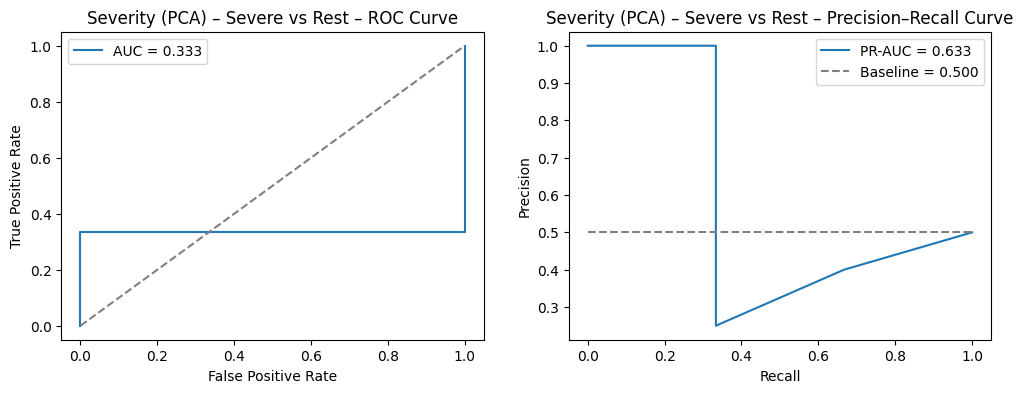

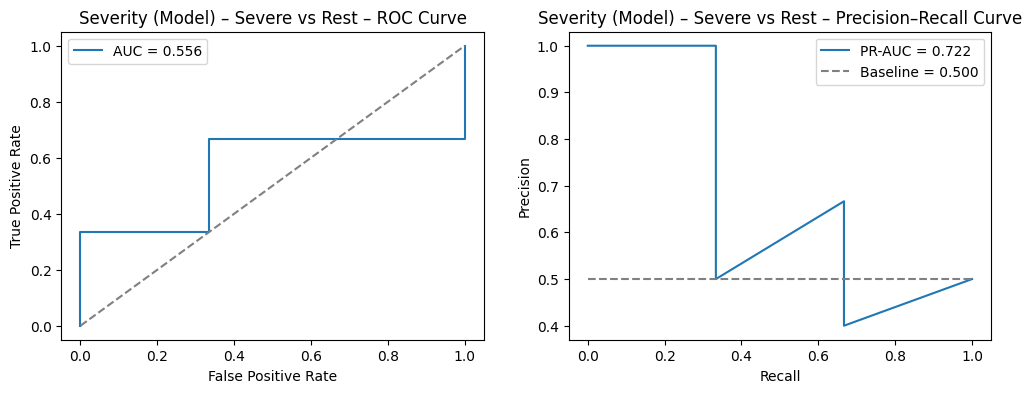

In [91]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Encode 3-class severity label
le = LabelEncoder()
y_sev = le.fit_transform(severity_per_individual)   # 0/1/2

# Train-test split
X_train_pca, X_val_pca, y_train_sev, y_val_sev = train_test_split(
    pca_feats, y_sev, test_size=0.2, stratify=y_sev, random_state=42
)

X_train_mod, X_val_mod, _, _ = train_test_split(
    model_feats, y_sev, test_size=0.2, stratify=y_sev, random_state=42
)

# Multi-class logistic regression
clf_pca = LogisticRegression(max_iter=500, multi_class="multinomial", solver="lbfgs")
clf_mod = LogisticRegression(max_iter=500, multi_class="multinomial", solver="lbfgs")

clf_pca.fit(X_train_pca, y_train_sev)
clf_mod.fit(X_train_mod, y_train_sev)

proba_pca = clf_pca.predict_proba(X_val_pca)       # (n,3)
proba_mod = clf_mod.predict_proba(X_val_mod)

# Multiclass AUC (macro-OVR)
auc_pca_sev = roc_auc_score(y_val_sev, proba_pca, multi_class="ovr", average="macro")
auc_mod_sev = roc_auc_score(y_val_sev, proba_mod, multi_class="ovr", average="macro")

print("=== SEVERITY (Multiclass) ===")
print("PCA   ROC-AUC:", auc_pca_sev)
print("MODEL ROC-AUC:", auc_mod_sev)

# Optional: plot ROC/PR curves for a specific class (e.g., severe/critical)
sev_class_index = list(le.classes_).index("severe/critical")
roc_auc, pr_auc = plot_roc_pr_curves(
    y_val_sev == sev_class_index,
    proba_pca[:, sev_class_index],
    "Severity (PCA) – Severe vs Rest"
)

roc_auc, pr_auc = plot_roc_pr_curves(
    y_val_sev == sev_class_index,
    proba_mod[:, sev_class_index],
    "Severity (Model) – Severe vs Rest"
)